# Loading data

In [1]:
models = ['13B', '6.7B', '6.7B_deduped']
checkpoints = [23000, 43000, 63000, 83000, 103000, 123000, 143000]
filepath = '/mnt/ssd-1/transformer-memorization'

In [2]:
import os
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

In [ ]:
memorization_results = {}
for model in models:
    for checkpoint in tqdm(checkpoints):
        filename = os.path.join(filepath, f'memorization_results_{model}-{checkpoint}.csv')
        memorization_results[f'{model}-{checkpoint}'] = pd.read_csv(filename)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

# Simple Multiprocess Manager

In [7]:
class MPManager:
    """
    A simple class for starting multiple processes simultaneously
    
    processes: Array[multiprocess.Process] instances
    """
    
    def __init__(self):
        self.processes = []
    
    def add(self, process):
        process.daemon=False
        self.processes.append(process)
        self.processes[-1].start()
    
    def join(self):
        for process in self.processes:
            process.join()

# Setting Params, styling

In [8]:
size = 25
params = {
    'legend.fontsize': 'large',
    'figure.figsize': (15,7),
    'axes.labelsize': size,
    'axes.titlesize': size,
    'xtick.labelsize': size*0.75,
    'ytick.labelsize': size*0.75,
    'axes.titlepad': 25,
    'font.family':'sans-serif',
    'font.weight':'bold',
}
plt.rcParams.update(params)

# Model Accuracy Linear Regression plot

In [ ]:
from itertools import cycle
import multiprocessing as mp
cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])
from sklearn.metrics import r2_score
    
def plot_linear_regression(model_name, evals, axis, color, precentile = 0):
    """
    Generates a linear regression plot and stores results in a json file
    
    model_name: String with model and it's checkpoint
    evals: Evaluation results of corresponding model on corresponding checkpoint 
    """
    top_percentile_accuracy = np.percentile(evals['accuracy'],precentile)
    top_percentile_evals = evals[evals['accuracy'] >= top_percentile_accuracy]
    
    indicies, accuracy = top_percentile_evals['index'], top_percentile_evals['accuracy']
    a,b = np.polyfit(indicies, accuracy,1)
    acc_best_fit = a*indicies + b
    
    results = {
        'slope': a,
        'variance': np.abs(acc_best_fit.iloc[0] - acc_best_fit.iloc[-1]),
        '% change': np.abs(acc_best_fit.iloc[0] - acc_best_fit.iloc[-1]/.iloc[0])
    }
    print(results)
    axis.plot(top_percentile_evals['index'], acc_best_fit,
        color=color, marker='3', label=model_name)

manager = MPManager()
fig = matplotlib.figure.Figure()
ax = fig.subplots()

for (model_name, evals) in tqdm(memorization_results.items()):
    
    model, checkpoint = model_name.split('-')
    if(model != '6.7B_deduped'): continue
    checkpoint = int(checkpoint)
    plot_linear_regression(model_name, evals,ax, next(cycol))

manager.join()
fig.suptitle("Memorization Accuracy")
fig.supxlabel("Sequence Index")
fig.supylabel("Accuracy")
ax.legend(loc='lower right')
fig.savefig('test.png')

  0%|          | 0/21 [00:00<?, ?it/s]

{'slope': 5.92715690460953e-13, 'variance': 1.3964494875950972e-05, '% change': 0.9186518522130944}
{'slope': -2.2706559681688756e-12, 'variance': 0.00010000012253344459, '% change': 0.9130163123375018}
{'slope': -2.0276459260011917e-12, 'variance': 0.0001308241024259721, '% change': 0.9098786016917085}
{'slope': 9.526011076014082e-14, 'variance': 8.097127609296706e-06, '% change': 0.908990633701098}
{'slope': -2.773586086061111e-13, 'variance': 2.9255839011269047e-05, '% change': 0.9060264595392501}
{'slope': 1.5302779082378718e-13, 'variance': 1.9275409760474704e-05, '% change': 0.9046988597182168}
{'slope': 4.2409286362239773e-14, 'variance': 6.210423995053893e-06, '% change': 0.9038566133329882}


In [ ]:
plt.scatter([1,2,3], [4.3,5.5,6.0],marker='4', cmap='viridis')

  0%|          | 0/7 [00:00<?, ?it/s]

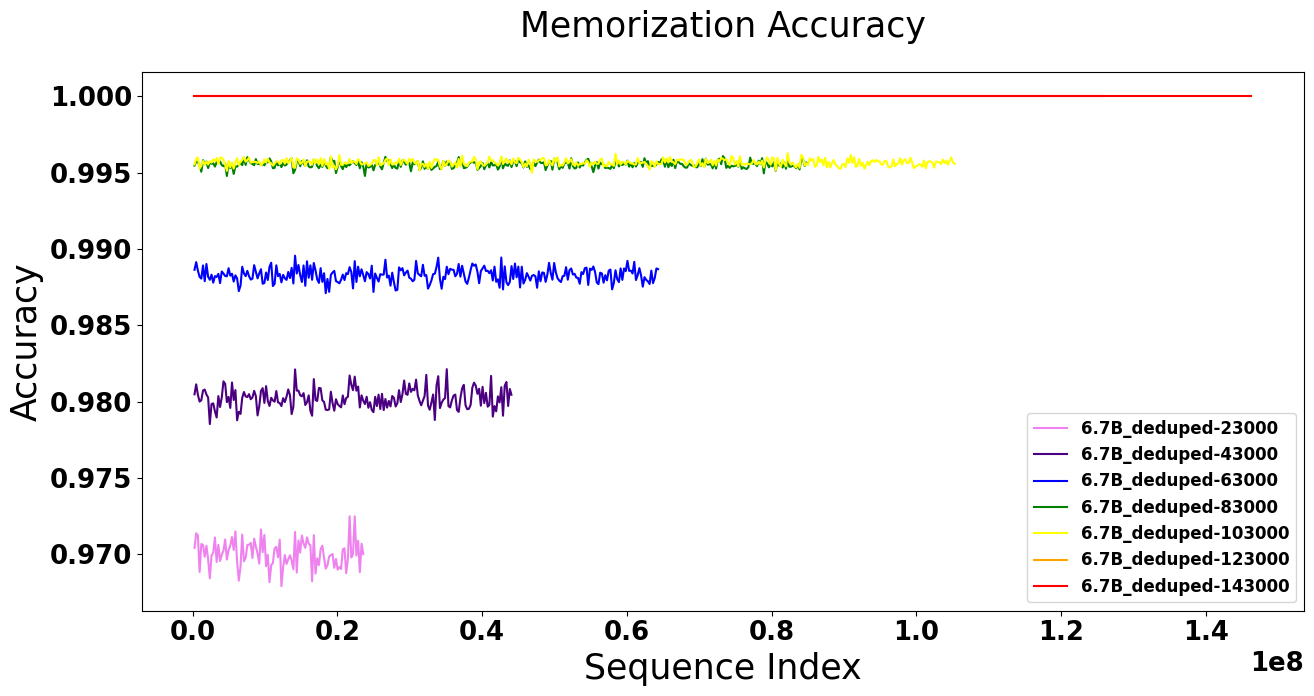

In [34]:
from itertools import cycle
cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])

for (name, results) in tqdm(memorization_results.items()):
    
    model, checkpoint = name.split('-')
    if(model == '13B'): continue
    
    indicies = []
    acc_means = []
    acc_errs = []
    acc_top_value = np.percentile(results['accuracy'],99)
    df_top = results[results['accuracy'] >= acc_top_value]
    for i in range(235600, len(results),235600):
        result = df_top[((i-235600) <= df_top['index']) & (df_top['index'] < i)]
        indicies.append(result['index'].iloc[-1])
        acc_means.append(result['accuracy'].mean())
        acc_errs.append(result['accuracy'].std()/np.sqrt(len(result)))
    plt.plot(indicies, acc_means, label=name, color=next(cycol))

plt.title("Memorization Accuracy")
plt.xlabel("Sequence Index")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.legend()

In [ ]:
for (name, results) in tqdm(memorization_results.items()):
    top_one_pctl_acc = np.percentile(results['accuracy'], 99)
    res = results.copy()
    res['accuracy'] = res['accuracy'].parallel_apply(lambda x:int(x > top_one_pctl_acc))
    indicies = []
    acc_means = []
    acc_errs = []
    for result in np.array_split(res, 10):
        indicies.append(result.index[-1])
        acc_means.append(result['accuracy'].mean())
        acc_errs.append(result['accuracy'].std()/np.sqrt(len(result)))
    plt.errorbar(indicies, acc_means, yerr = acc_errs, label=name, capsize=5)


In [39]:
for checkpoint in checkpoints:
    name_13B = f'13B-{checkpoint}'
    name_6_7B = f'6.7B-{checkpoint}'
    df = pd.DataFrame()
    df['13B_accuracy'] = memorization_results[name_13B]['accuracy']
    df['6.7B_accuracy'] = memorization_results[name_6_7B]['accuracy']
    print(f'{checkpoint} correlation:')
    print(df.corr())
    
    

23000 correlation:
               13B_accuracy  6.7B_accuracy
13B_accuracy       1.000000       0.000061
6.7B_accuracy      0.000061       1.000000
43000 correlation:
               13B_accuracy  6.7B_accuracy
13B_accuracy       1.000000       0.000253
6.7B_accuracy      0.000253       1.000000
63000 correlation:
               13B_accuracy  6.7B_accuracy
13B_accuracy       1.000000       0.000112
6.7B_accuracy      0.000112       1.000000
83000 correlation:
               13B_accuracy  6.7B_accuracy
13B_accuracy       1.000000       0.000035
6.7B_accuracy      0.000035       1.000000
103000 correlation:
               13B_accuracy  6.7B_accuracy
13B_accuracy        1.00000        0.80597
6.7B_accuracy       0.80597        1.00000
123000 correlation:
               13B_accuracy  6.7B_accuracy
13B_accuracy       1.000000       0.813102
6.7B_accuracy      0.813102       1.000000
143000 correlation:
               13B_accuracy  6.7B_accuracy
13B_accuracy       1.000000       0.815245
6.7B

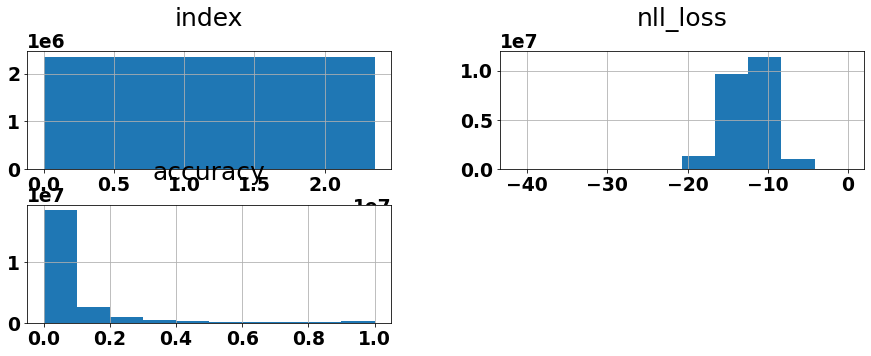

In [40]:
for (name, df) in memorization_results.items():
    df.hist()
    break

In [33]:
import matplotlib
import scipy.signal
from itertools import cycle
from multiprocessing import Process
cycol = cycle(['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red'])

def normalized_corr(x, y):
    x -= x.mean()
    y -= y.mean()
    corr = scipy.signal.correlate(x, y)
    corr /= (np.sqrt(np.sum(x**2) * np.sum(y**2)))
    corr_lags = scipy.signal.correlation_lags(len(x), len(y))
    return corr, corr_lags

def save_cross_correlation(name_i, evals_i, memorization_results):
    model_i, checkpoint_i = name_i.split('-')
    fig = matplotlib.figure.Figure()
    matplotlib.rcParams.update(params)
    ax = fig.add_subplot()
    corr_peaks = {}
    for (name_j, evals_j) in tqdm(memorization_results.items()):
        model_j, checkpoint_j = name_j.split('-')
        if(model_i != model_j): continue
        if(int(checkpoint_j) <= int(checkpoint_i)):
            continue
        
        x = evals_i['accuracy']
        y = evals_j['accuracy'][:len(x)]
        corr, corr_lags = normalized_corr(x, y)
        plot_color = next(cycol)
        plot_label = f'{model_i}: {checkpoint_i} and {checkpoint_j}'
        ax.plot(corr_lags, corr, label = plot_label,color=plot_color)
        corr_peaks[plot_label] = np.max(corr)
        ax.plot(corr_lags[np.argmax(corr)], np.max(corr), '_', 
                 markersize=32.0, markeredgewidth=2.0, color=plot_color)
    
    handles, labels = fig.gca().get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: -corr_peaks[t[0]]))
    fig.suptitle("Memorization Accuracy Cross Correlation")
    fig.supxlabel("Lags")
    ax.set_xlim(-5e4, 5e4)
    fig.supylabel("Cross correlation")
    if(model_i == '6.7B' and checkpoint_i == '83000'):
        ax.legend(handles, labels, loc='upper left')
    else:
        ax.legend(handles, labels, loc='upper right')
    fig.savefig(f'./plots/{name_i}-correlation.png')


processes = []
for (name_i, evals_i) in memorization_results.items():
    model_i, checkpoint_i = name_i.split('-')
    if checkpoint_i == "143000":
        continue
    processes.append(Process(target=save_cross_correlation, args=(name_i, 
        evals_i, memorization_results)))

for process in processes:
    process.start()
for process in processes:
    process.join()

13B-23000
13B-2300013B-23000

13B-43000
13B-43000
13B-63000
13B-2300013B-23000

13B-23000
13B-43000
13B-43000
13B-43000
13B-63000
13B-63000
13B-83000
13B-10300013B-63000

13B-83000
13B-10300013B-83000

13B-123000
6.7B-23000
6.7B-23000
6.7B-43000
6.7B-63000
6.7B-23000
6.7B-230006.7B-43000
6.7B-23000
6.7B-43000

6.7B-63000
6.7B-430006.7B-83000

6.7B-63000
6.7B-83000
6.7B-230006.7B-103000

6.7B-43000
6.7B-63000
6.7B-83000
6.7B-103000
6.7B-123000
